# city-map-texas: Assignment-0

**Rangarajan - Abhi - ( uxs876 )**






## Learning Objectives


*   Read data from a file and Create a graph
*   Implement Uninformed & Informed searching strategies
*   Apply different searching strategies for the given problem
*   Analyze and Compare the searching strategies


## Description

This assignment is focused on **python file reading, graph creation** and implementation of **search algorithms**.
In the following sections, you will complete a series of tasks for a made up problem of *Fluvirus in Texas*.

*   Fluvirus is non-discriminatory, in the sense that it can spread from one city to any other city. The only goal of the virus is to spread to all cities in Texas. Find a possible way for the virus to spread (Uninformed Search).
*   To counter the effect of the virus, vaccine needs to be distributed to all cities. One city has more demand than supply, whereas one city has a shortage of vaccines. The goal is to find an **optimal** strategy to transport the vaccine (Informed Search) from the city with high supply (low demand) to the city with low supply (high demand).

The base structure and comments are provided on what should be done. You can use some libraries that help support you for the successful completion of the assignment. However, you **CANNOT** use a complete library for the search algorithms. You can get pieces of code from online, but please cite the source properly.


# Reading Data Files & Creating a 2D Graph

##

In this section, you will write code to read the data files provided, CitiesTexas.csv and CitiesDistancesTexas.csv, and create a 2D graph consisting of nodes and edges. The goal is to use this graph for the 2 search agents that you will create in the next section.

Provided with this lab, on Canvas, you will find 2 csv files:

*   **city-texas.csv** - This file contains a list of coordinates for selected cities in Texas, in the following format:
```
San Antonio,29.4685,-98.5254
```
The above line means that San Antonio is located at the latitude and longitude of 29.4685 N and 98.5254 W respectively. Note that the '-ve' sign denotes 'S' for latitude and 'W' for longitude. While performing calculations you will need to ignore the sign.

*   **city-distances-texas.csv** - This file contains distance values between two cities of Texas, if a path exists, in the following format:
```
San Antonio,New Braunfels,30.80876734
```
The above line denotes that there should be an edge between *San Antonio* and *New Braunfels* and the weight on that edge, i.e. the distance, is *30.80876734*.

In the code blocks below, handle the logic for the graph. Load the graph data from the give files and display a 2D graph of the given data, with labeled nodes and edges. Create as many functions or code blocks as needed.

##

Overlay the 2D graph on an image of the Texas state map.





In [530]:
# Add only your imports here
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time as time
import heapq
from typing import Any, Tuple, Union


In [531]:
# Assume that the data files are in the following folder -- THIS WILL BE USED BY THE TA
basePath = r"/content/drive/My Drive/Colab Notebooks/Artificial Intelligence/Data"
basePath = r"."

TEXAS_MAP: str = rf'{basePath}/cities-texas-map.png'

map_grid = ( 22 * 10, 9 * 10 )

In [532]:
# Load Data
def load_csvs() -> Tuple[ pd.DataFrame, pd.DataFrame ]:
    city_coords: pd.DataFrame = pd.read_csv( fr'{ basePath }/city-texas.csv', names=[ 'City', 'Longitude', 'Latitude' ] )
    city_distances: pd.DataFrame = pd.read_csv( fr'{ basePath }/city-distance-texas.csv', names=[ 'City_From', 'City_To', 'Distance' ] )

    print( city_coords )
    print()
    print( city_distances )
    print()
    
    return city_coords, city_distances


In [533]:
# Setup Graph and Nodes

class City():

    def __init__( self, name: str, longitude: float, latitude: float ) -> None:
        self.name: str = name
        self.longitude: float = longitude
        self.latitude: float = latitude

    def __str__( self ) -> str:
        return f'Name: { self.name }, Longitude: { self.longitude }, Latitude: { self.latitude }'

    def __repr__( self ) -> str:
        return f'{ self.__str__() }\n\n'

    def get_coords( self ) -> Tuple[ float, float ]:
        return self.longitude, self.latitude

class Node():
    def __init__( self, city: City = None, routes: dict = None ) -> None:
        self.city: City = city
        self.routes: dict = routes

    def __str__( self ) -> str:
        return f'City:\n    { self.city }\nRoutes:\n   { self.routes }'

    def __repr__( self ) -> str:
        return f'{ self.__str__() }\n\n'

    def set_routes( self, routes: dict ) -> None:
        self.routes = routes

    def get_routes( self ) -> Union[ dict | None ]:
        return self.routes

class Graph():

    def __init__( self, graph: list ) -> None:
        self.graph: list = graph

    def __str__( self ) -> str:
        return f'{ self.graph }'

    def insert( self, node: Node ) -> None:
        self.graph.append( node )

    def get_node_by_name( self, name ) -> Union[ Node, None ]:
        return next( ( node for node in self.graph if node.city.name == name ), None )
    
    
    def get_heuristic( self, node1: Node, node2: Node ) -> float:
        return abs( node1.city.longitude - node2.city.longitude ) + abs( node1.city.latitude - node2.city.latitude )
    


In [534]:
# Populate Graph

cities, city_routes = load_csvs()

city_graph: Graph = Graph( [] )

for i, rows in cities.iterrows():
    temp: Node = Node()
    temp.city = City( name=rows[ 'City' ], longitude=rows[ 'Longitude' ], latitude=rows[ 'Latitude' ] )

    routes: dict = {}
    routes |= (
        city_routes.loc[ city_routes[ 'City_From' ] == temp.city.name ]
        .drop( columns=[ 'City_From' ] )
        .to_dict( orient='tight' )
        .get( 'data' )
    )
    routes.update( city_routes.loc[ city_routes[ 'City_To' ] == temp.city.name ].drop( columns=[ 'City_To' ] ).to_dict( orient='tight' ).get( 'data' ) )
    temp.routes = routes

    city_graph.insert( temp )


               City  Longitude  Latitude
0           Abilene    32.4543  -99.7384
1             Alice    27.7556  -98.0653
2          Amarillo    35.1989 -101.8310
3            Austin    30.3006  -97.7517
4          Beaumont    30.0850  -94.1451
5       Brownsville    25.9980  -97.4565
6   College Station    30.5852  -96.2960
7          Columbus    29.7055  -96.5563
8    Corpus Christi    27.7261  -97.3755
9           Dalhart    36.0579 -102.5123
10           Dallas    32.7936  -96.7662
11          Del Rio    29.3708 -100.8800
12          El Paso    31.8479 -106.4309
13       Fort Worth    32.7812  -97.3472
14        Galveston    29.5112  -95.1979
15         Gonzalez    29.5126  -97.4472
16          Houston    29.7869  -95.3905
17    Jamaica Beach    29.1905  -94.9801
18           Kenedy    28.8176  -97.8518
19           Laredo    27.5617  -99.4874
20          Lubbock    33.5642 -101.8871
21          McAllen    26.2273  -98.2471
22          Midland    32.0249 -102.1137
23    New Braunf

In [535]:
# Display a 2D graph of the given data.

print( city_graph )


[City:
    Name: Abilene, Longitude: 32.4543, Latitude: -99.7384
Routes:
   {'San Angelo': 95.26906977}

, City:
    Name: Alice, Longitude: 27.7556, Latitude: -98.0653
Routes:
   {'Laredo': 98.54431104, 'Three Rivers': 51.26861733, 'McAllen': 113.6156404}

, City:
    Name: Amarillo, Longitude: 35.1989, Latitude: -101.831
Routes:
   {'Dalhart': 85.07238807, 'Lubbock': 122.9827931}

, City:
    Name: Austin, Longitude: 30.3006, Latitude: -97.7517
Routes:
   {'San Marcos': 30.71742595, 'Round Rock': 18.46400955, 'College Station': 106.7588224, 'Houston': 165.9076541}

, City:
    Name: Beaumont, Longitude: 30.085, Latitude: -94.1451
Routes:
   {'Houston': 99.57951346}

, City:
    Name: Brownsville, Longitude: 25.998, Latitude: -97.4565
Routes:
   {'McAllen': 59.20599771}

, City:
    Name: College Station, Longitude: 30.5852, Latitude: -96.296
Routes:
   {'Waco': 97.82787143, 'Houston': 99.20917694, 'Austin': 106.7588224}

, City:
    Name: Columbus, Longitude: 29.7055, Latitude: -96.5

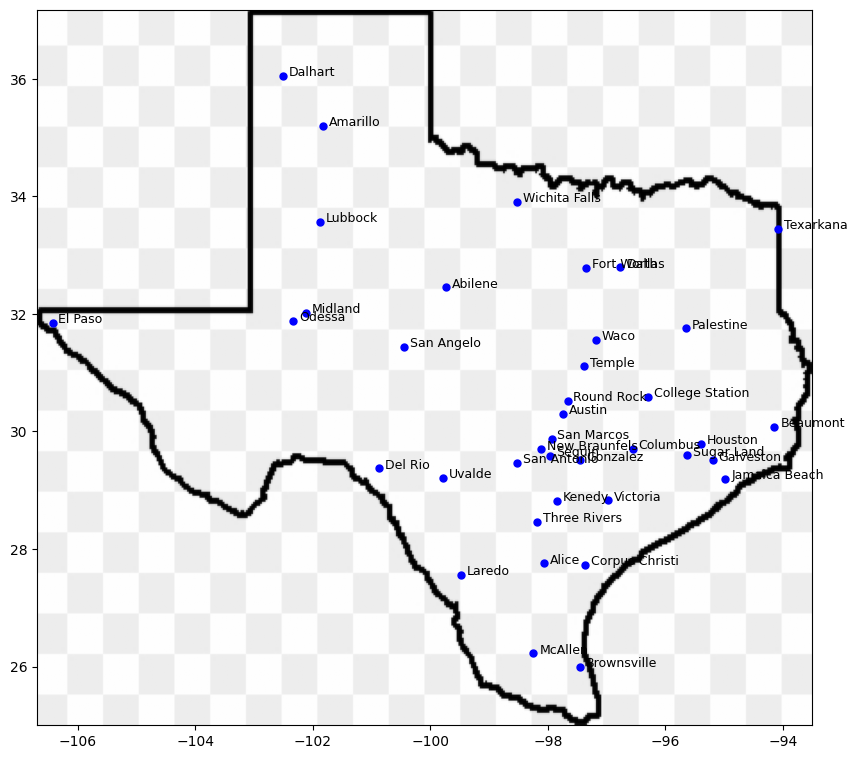

In [536]:
# Visualize Graph

def setup_plot() -> Tuple:

    image = mpimg.imread( TEXAS_MAP )

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, extent=[-106.69, -93.5, 25, 37.18])
    return ( fig, ax )

def draw_full_graph( ax ) -> None:
    for _, row in cities.iterrows():
        city = row['City']
        lat = row['Longitude']
        lon = row['Latitude']
        ax.plot( lon, lat, 'bo', markersize=5 )  # Plot city as blue circles ('bo')
        ax.text( lon + 0.1, lat, city, fontsize=9, color='black' )  # Add city names slightly offset
    
 
fig, ax = setup_plot()
draw_full_graph( ax )
plt.show()

# Virus Spread - Uninformed Search Agent

##

In this section, you will use the graph created in the previous section and create an *uninformed search* agent that will print the path how the virus will spread to all the provided Texas cities. The first confirmed case of the virus was in **Three Rivers** and starts spreading from there. The virus does not discriminate and it needs to spread to all the cities of Texas.

In the following code block, write code to implement **any** uninformed search strategy. You are free to create more code blocks if needed. As the output, print

*   The path or sequence of cities that will be infected by the spread of Fluvirus.
*   The distance travelled by the selected virus spreading strategy.

##
On the 2D graph and the Texas state map, overlay the selected path along with the cities visited.

In [537]:
# Setup Virus

class Virus():
    def __init__( self, name: str, starting_city: str ) -> None:
        self.name: str = name
        self.starting_city: str = starting_city
        self.infected_cities: list = []

    def __str__( self ) -> str:
        return f'Virus Name: { self.name }, Starting City: { self.starting_city }, Visited Cities: { self.infected_cities }'

    def __repr__( self ) -> str:
        return f'{ self.__str__() }\n\n'


In [538]:
# Draw route on plot

def draw_route( city_from: str, city_to: str, cities_graph: Graph, ax, plot_points: bool =  True, plot_origin: bool = True ) -> None:
    city_f: City = cities_graph.get_node_by_name( city_from ).city
    city_t: City = cities_graph.get_node_by_name( city_to ).city
    
    lats: list = [ city_f.get_coords()[ 1 ], city_t.get_coords()[ 1 ]  ]
    lons: list = [ city_f.get_coords()[ 0 ], city_t.get_coords()[ 0 ]  ]

    if plot_points:
        
        if plot_origin:
            
            ax.plot( lats[ 0 ], lons[ 0 ], 'bo', markersize=5 )  # Plot city as blue circles ('bo')
            ax.text( lats[ 0 ] + 0.1, lons[ 0 ], city_f.name, fontsize=9, color='black' )  # Add city names slightly offset
            
        ax.plot( lats[ 1 ], lons[ 1 ], 'bo', markersize=5 )  # Plot city as blue circles ('bo')
        ax.text( lats[ 1 ] + 0.1, lons[ 1 ], city_t.name, fontsize=9, color='black' )  # Add city names slightly offset

    ax.plot( lats, lons, 'red', lw=1 )


In [539]:
# Implement ANY uninformed search strategy for the spread of coronavirus from the starting city of 'Three Rivers'
# Uninformed Search to spread to all cities

def uninformed_bfs( virus: Virus, cities_graph: Graph, ax ) -> None:
    queue: list = [ virus.starting_city ]

    last_city_queue: list = []
    last_city: str = virus.starting_city

    distance: float = 0.0

    nodes_till_next_layer: int = 0
    layer_nodes_queue: list = []

    while queue:
        current_city: str = queue.pop( 0 )

        if current_city not in virus.infected_cities:
            print( f'Virus `{ virus.name }` spreading to { current_city }' )
            virus.infected_cities.append( current_city )

            available_routes = cities_graph.get_node_by_name( current_city ).get_routes()

            if last_city != current_city:
                distance += available_routes.get( last_city )
                draw_route( last_city,  current_city, cities_graph, ax, plot_points=False )

            for key in virus.infected_cities:
                available_routes.pop( key, None )

            for key in queue:
                available_routes.pop( key, None )

            if len( available_routes ) > 0:
                layer_nodes_queue.append( len( available_routes ) )
                last_city_queue.append( current_city )

            if nodes_till_next_layer == 0 and last_city_queue:
                last_city = last_city_queue.pop( 0 )
                nodes_till_next_layer = layer_nodes_queue.pop( 0 )

            nodes_till_next_layer -= 1
            queue.extend( available_routes.keys() )

    print( f'\nVirus `{ virus.name }` started in `{ virus.starting_city }` and ended in `{ current_city }`, with a total distance of `{ distance }` miles, infecting `{ len( virus.infected_cities ) }` cities')



Virus `Flu` spreading to Three Rivers
Virus `Flu` spreading to Kenedy
Virus `Flu` spreading to San Antonio
Virus `Flu` spreading to Corpus Christi
Virus `Flu` spreading to Alice
Virus `Flu` spreading to New Braunfels
Virus `Flu` spreading to Seguin
Virus `Flu` spreading to Uvalde
Virus `Flu` spreading to San Angelo
Virus `Flu` spreading to Victoria
Virus `Flu` spreading to Laredo
Virus `Flu` spreading to McAllen
Virus `Flu` spreading to San Marcos
Virus `Flu` spreading to Gonzalez
Virus `Flu` spreading to Columbus
Virus `Flu` spreading to Del Rio
Virus `Flu` spreading to Midland
Virus `Flu` spreading to Lubbock
Virus `Flu` spreading to Abilene
Virus `Flu` spreading to Brownsville
Virus `Flu` spreading to Austin
Virus `Flu` spreading to Houston
Virus `Flu` spreading to Odessa
Virus `Flu` spreading to Amarillo
Virus `Flu` spreading to Round Rock
Virus `Flu` spreading to College Station
Virus `Flu` spreading to Beaumont
Virus `Flu` spreading to Galveston
Virus `Flu` spreading to Sugar La

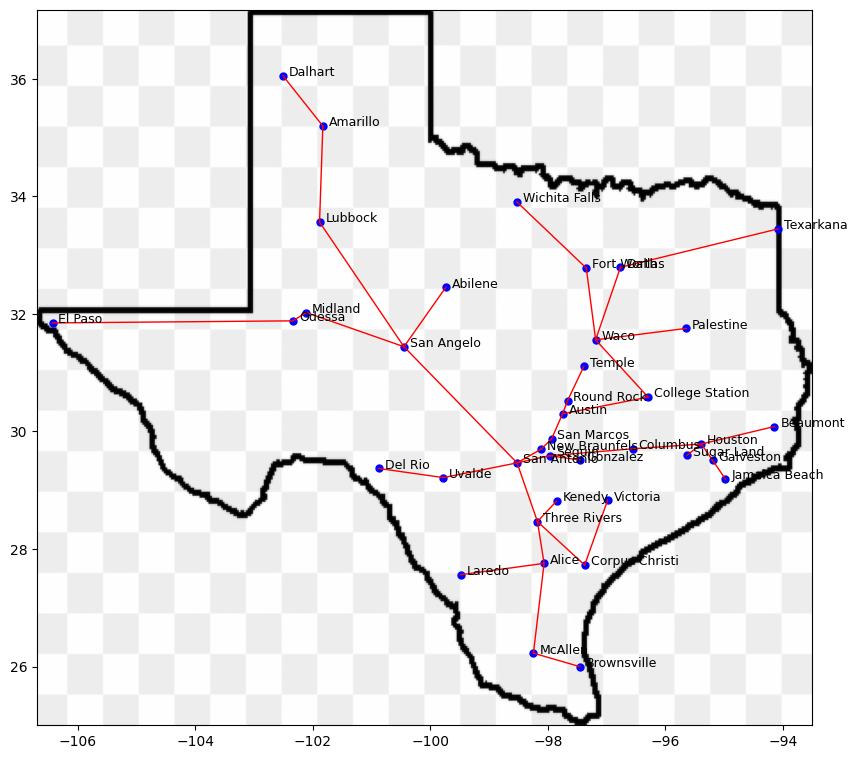

In [540]:
# Run the simulation

virus1: Virus = Virus( name='Flu', starting_city='Three Rivers' )
print()
_, ax = setup_plot()
draw_full_graph(ax)
uninformed_bfs( virus1, city_graph, ax )
plt.show()


# Vaccine Transportation - Informed Search Agent

##

In this section, you will create an *informed search* agent that will be used to transport the vaccine. The city of **San Antonio** has more supply of vaccine than the demand. The goal is to create an **optimal strategy** to transport the vaccine and make it available at the highly affected city of **College Station**, where there is a shortage of vaccines.

In the following code block, write code to implement an **optimal** informed search strategy. You are free to create more code blocks if needed. As the output, print

*   The path / sequence of cities that will be visited in the optimal vaccine transportation strategy.
*   The total distance travelled in the optimal vaccine transportation strategy.


##
On the 2D graph and the Texas state map, overlay the selected path along with the cities visited.

In [541]:
# Informed search

def informed_Astar( starting_city: str, ending_city: str, cities_graph: Graph, ax ) -> None:
    queue: list = [ ( 0, starting_city, [ starting_city ] ) ]
    cost_so_far: dict = { starting_city: 0 }

    while queue:
        _, current_city, path = heapq.heappop( queue )

        if current_city == ending_city:
            break

        for neighbor, distance in cities_graph.get_node_by_name( current_city ).get_routes().items():
            tentative_cost = cost_so_far[ current_city ] + distance

            if neighbor not in cost_so_far or tentative_cost < cost_so_far[ neighbor ]:
                cost_so_far[ neighbor ] = tentative_cost
                priority = tentative_cost + cities_graph.get_heuristic( cities_graph.get_node_by_name( neighbor ), cities_graph.get_node_by_name( ending_city ) )
                heapq.heappush( queue, ( priority, neighbor, path + [ neighbor ] ) )

    print( f'\nThe shortest path from `{ starting_city }` to `{ ending_city }` is `{ cost_so_far[ ending_city ] }` miles long' )
    print( f'The route to take is { path }' )
    
    draw_route( path[ 0 ],  path[ 1 ], cities_graph, ax )
    for i in range( 1, len( path ) - 1 ):
        draw_route( path[ i ],  path[ i + 1 ], cities_graph, ax, plot_origin=False )



The shortest path from `San Antonio` to `College Station` is `186.77450141` miles long
The route to take is ['San Antonio', 'New Braunfels', 'San Marcos', 'Austin', 'College Station']


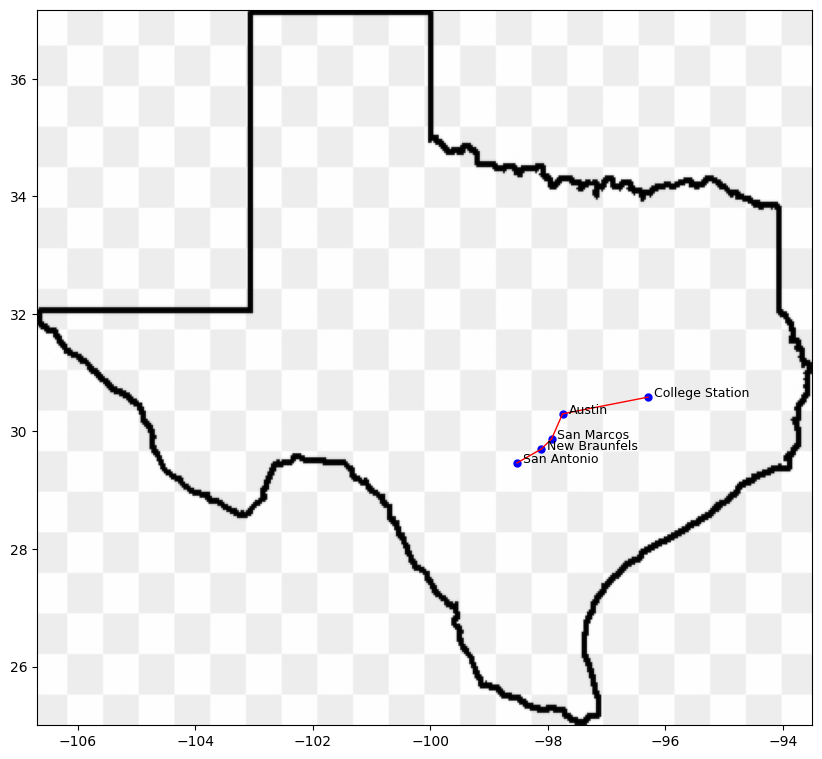

In [542]:
# Run Simulation

_, ax = setup_plot()
informed_Astar( starting_city='San Antonio', ending_city='College Station', cities_graph=city_graph, ax=ax )
plt.show()

# Submission Instructions

1.   Complete all tasks above - **File MUST contain the output for ALL cells**
2.   Export this notebook as .ipynb
      (File > Download as ipynb)
3.   Upload the .ipynb file on Canvas

## Rubric

*   (1.5 points) Reading Data files & Creating a 2D Graph
*   (1.5 points) Virus Spread - Uninformed Search Agent
*   (1.5 points) Vaccine Transportation - Informed Search Agent
*   (0.5 points) For the Texas map image, overlay the 2D graph and the paths selected by the search agents



